# Variational Autoencoder v PCA

In this notebook I want to show two types of dimensionality reduction for tabular data: PCA and Autoencoders.

I use the [wine dataset](https://archive.ics.uci.edu/ml/datasets/wine) to show how Variational Autoencoder (VAE) with PyTorch on tabular data works and compare it to the classic PCA approach. I use the PCA/VAE to reduce the dimensionality of dataset, in this case don to 3 Variables (embeddings). I then plot the embeddings in a 3D graph to show how VAE is similar to a PCA but works in a non-linear way. 

## TODO

* safe model
* safe latent space

# Imports

In [153]:
# mamba create -n sdiv_spectra python=3.10
# mamba init
# mamba activate sdiv_spectra
# mamba install pytorch matplotlib scikit-learn pandas -c conda-forge

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
import os
import csv
import random
from scipy.signal import savgol_filter

In [154]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Dataset & preprocessing

In [155]:
# path to dataset
data_path = '/mnt/gsdata/users/kattenborn/data/sdiv_spectra/canopy_data/DB_47_Meta_EC.csv'
#data_path = 'G:/My Drive/projects/project_sPectra/DB_47_Meta_EC.csv'

# path for model output
model_out_dir = '/mnt/gsdata/users/kattenborn/data/sdiv_spectra/dimred_canopy_v7_5lv/'
# check if model output directory exists and create it if not
if not os.path.exists(model_out_dir):
    os.makedirs(model_out_dir)

In [156]:
df = pd.read_csv(data_path, sep=',')
df

/tmp/ipykernel_2698635/3788649274.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep=',')


,Unnamed: 0,Species,dataset,numSamples,LandCover,Tool,Sensor,Site,Year,Al_area_mg_cm2,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0,Agrostis sp,1,73,Grassland,Proximal,ASD FieldSpec 3,"BattSP, Belgium",2016.0,NaN,...,-6.220955e-01,-6.357021e-01,-5.100964e-01,-4.273743e-01,-3.817722e-01,-3.606211e-01,-3.365253e-01,-2.537969e-01,-1.047274e-01,-8.562174e-02
1,1,Agrostis sp,1,73,Grassland,Proximal,SVC HR-1024TM,"DeMatCem, Belgium",2016.0,NaN,...,2.922402e-02,-6.810113e-02,-1.440324e-01,-2.166700e-01,-1.766549e-01,-1.124554e-01,-4.854697e-02,7.510346e-03,3.710629e-02,3.651872e-02
2,2,Agrostis sp,1,73,Grassland,Proximal,SVC HR-1024TM,"HaachtBev, Belgium",2016.0,NaN,...,-7.103488e-02,-1.609262e-01,-1.035611e-01,-3.517213e-02,5.051771e-02,1.400784e-01,1.920989e-01,2.155951e-01,2.117149e-01,1.619342e-01
3,3,Agrostis sp,1,73,Grassland,Proximal,ASD FieldSpec 3,"HaachtHol, Belgium",2016.0,NaN,...,-6.685111e-01,1.680976e-01,2.704971e-01,5.217226e-02,-4.300934e-01,-3.218315e-01,-2.314438e-01,-2.337150e-01,-5.511845e-02,-6.315379e-03
4,4,Angelica sylvestris,1,73,Grassland,Proximal,SVC HR-1024TM,"HaachtBev, Belgium",2016.0,NaN,...,3.584023e-02,4.732150e-02,7.792805e-02,1.069778e-01,8.317470e-02,5.113662e-02,4.280231e-02,4.788594e-02,4.579319e-02,3.343637e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5878,5878,Fagus grandifolia,47,166,NaN,Airborne,CASI-1500 and SASI-805,NaN,2022.0,NaN,...,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02,1.575385e-02
5879,5879,Populus tremuloides,47,166,NaN,Airborne,CASI-1500 and SASI-806,NaN,2022.0,NaN,...,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19,1.100000e-19
5880,5880,Populus tremuloides,47,166,NaN,Airborne,CASI-1500 and SASI-807,NaN,2022.0,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5881,5881,Populus tremuloides,47,166,NaN,Airborne,CASI-1500 and SASI-808,NaN,2022.0,NaN,...,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02,2.297500e-02


In [157]:
spectracols = [col for col in df.columns if col.isdigit() and 400 <= int(col) <= 2500]
spectraindex = [df.columns.get_loc(col) for col in spectracols]

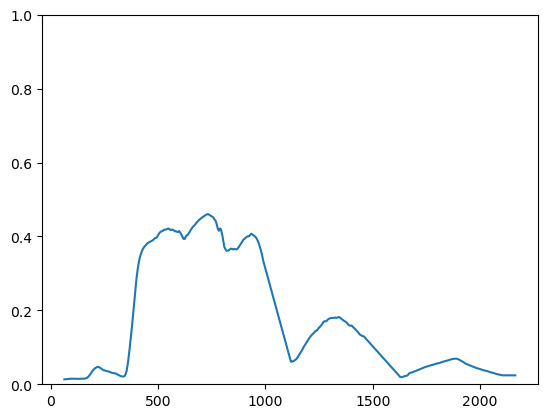

In [158]:
plt.plot(spectraindex, df.iloc[3000, spectraindex])
plt.ylim(0, 1)
plt.show()

## Smooth spectra using Savitzky-Golay filter

In [159]:
spectra = df.iloc[:, spectraindex]

In [160]:
# check if df has nan or infinite values and replace them with a column mean value
if spectra.isnull().values.any():
    spectra.fillna(spectra.mean(), inplace=True)

/tmp/ipykernel_2698635/1833467490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectra.fillna(spectra.mean(), inplace=True)


In [161]:
spectra_filtered = spectra.copy()

In [162]:
# Apply Savitzky Golay filter to separate regions (to avoid smoothing in overly noisy regions)
spectra_filtered.loc[:,  '400':'1350'] = spectra.loc[:, '400':'1350'].apply(lambda row: savgol_filter(row, window_length=45, polyorder=1), axis=1).to_list()
spectra_filtered.loc[:, '1430':'1801'] = spectra.loc[:, '1430':'1801'].apply(lambda row: savgol_filter(row, window_length=45, polyorder=1), axis=1).to_list()
spectra_filtered.loc[:, '2050':'2500'] = spectra.loc[:, '2050':'2500'].apply(lambda row: savgol_filter(row, window_length=45, polyorder=1), axis=1).to_list()

# Apply Savitzky Golay filter
#spectra_filtered = spectra.apply(lambda row: savgol_filter(row, window_length=25, polyorder=1), axis=1)

# convert list to a array
#spectra_filtered = pd.DataFrame(np.array(spectra_filtered.to_list()))

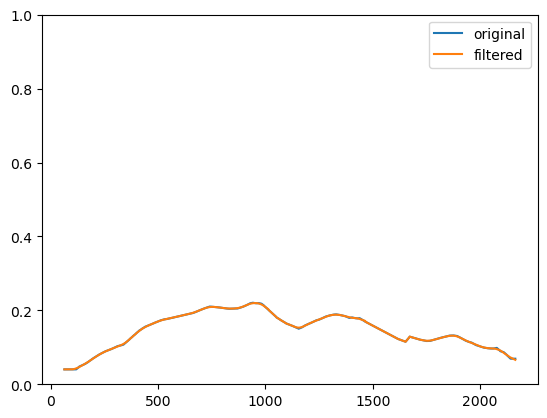

In [163]:
# sample random index from the dataset
sample_index = random.randint(0, len(df))

# plot original and filtered spectra
plt.plot(spectraindex, df.iloc[sample_index, spectraindex], label = 'original')
plt.plot(spectraindex, spectra_filtered.iloc[sample_index], label = 'filtered')
plt.legend(loc = 'upper right')
plt.ylim(0, 1)
plt.show()

In [164]:
df.iloc[:, spectraindex] = spectra_filtered

## Data loading function

In [165]:
column_prefixes = ['Species', 'dataset', 'LandCover', 'Tool', 'Sensor', 'Site', 
 'Al_area_mg_cm2', 'Al_mass_mg_g', 'Anth_area_ug_cm2', 'Anth_mass_mg_g', 'Boron_area_mg_cm2', 'Boron_mass_mg_g', 'C_area_mg_cm2', 'C_mass_mg_g', 'Ca_area_mg_cm2', 'Ca_mass_mg_g', 
 'Car_area_ug_cm2', 'Car_mass_mg_g', 'Cellulose_mg_cm2', 'Cellulose_mg_g', 'Chl_area_ug_cm2', 'Chl_mass_mg_g', 'Cu_area_mg_cm2', 'Cu_mass_mg_g', 'EWT_mg_cm2', 'Fiber_mg_cm2', 'Fiber_mg_g',
   'Flavonoids_area_mg_cm2', 'Flavonoids_mass_mg_g', 'Iron_area_mg_cm2', 'Iron_mass_mg_g', 'LAI_m2_m2', 'LMA_g_m2', 'LDMC_g_g', 'LWC%', 'Lignin_mg_cm2', 'Lignin_mg_g', 'Mg_area_mg_cm2', 'Mg_mass_mg_g',
     'Mn_area_mg_cm2', 'Mn_mass_mg_g', 'N_area_mg_cm2', 'N_mass_mg_g', 'NSC_mg_cm2', 'NSC_mg_g', 'Phenolics_area_mg_cm2', 'Phenolics_mass_mg_g', 'P_area_mg_cm2', 'P_mass_mg_g', 'Potassium_area_mg_cm2',
       'Potassium_mass_mg_g', 'Protein_g_m2', 'RWC%', 'Starch_area_mg_cm2', 'Starch_mass_mg_g', 'Sugar_area_mg_cm2', 'Sugar_mass_mg_g', 'S_area_mg_cm2', 'S_mass_mg_g', 'Zn_area_mg_cm2', 'Zn_mass_mg_g']

metaindex = [df.columns.get_loc(col) for prefix in column_prefixes for col in df.filter(like=prefix).columns]

In [166]:
def load_data(path):
    # read in from csv
    df = pd.read_csv(path, sep=',')

    # set values in the columns 400-410, 1351–1430, 1801–2050 and 2451–2501 to 0
    df.loc[:, '400':'410'] = 0
    df.loc[:, '1351':'1430'] = 0
    df.loc[:, '1801':'2050'] = 0
    df.loc[:, '2451':'2500'] = 0
    
    # replace nan with -99
    df = df.fillna(-99)
    df_base = df.iloc[:, spectraindex]
    df_meta = df.iloc[:,metaindex]#.values
    x = df_base.values.reshape(-1, df_base.shape[1]).astype('float32')
    # standardize values
    standardizer = preprocessing.StandardScaler()
    x = standardizer.fit_transform(x)    
    return x, standardizer , df_meta

In [167]:
def numpyToTensor(x):
    x_train = torch.from_numpy(x).to(device)
    return x_train

# Dimension reduction via principal component analysis (PCA)

In [168]:
x_pca, standardizer, df_meta = load_data(data_path)

/tmp/ipykernel_2698635/428913080.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',')


In [169]:
x_pca.shape

(5883, 2101)

In [170]:
# calculate PCA
n_comp = 10
pca = PCA(n_components=n_comp)
principalComponents = pca.fit_transform(x_pca)
columns = ['principal component ' + str(i+1) for i in range(n_comp)]
principalDf = pd.DataFrame(data = principalComponents, columns = columns)

In [171]:
# calculate explained variance and plot it
explained_variance = pca.explained_variance_ratio_ * 100
print('expl. variance per PC:', explained_variance)
print('cumulative expl. variance:', sum(explained_variance))

expl. variance per PC: [49.086456   28.599163    4.859481    2.3624399   1.4185767   1.3273618
  0.8550195   0.7703483   0.5236281   0.46049184]
cumulative expl. variance: 90.26296639442444


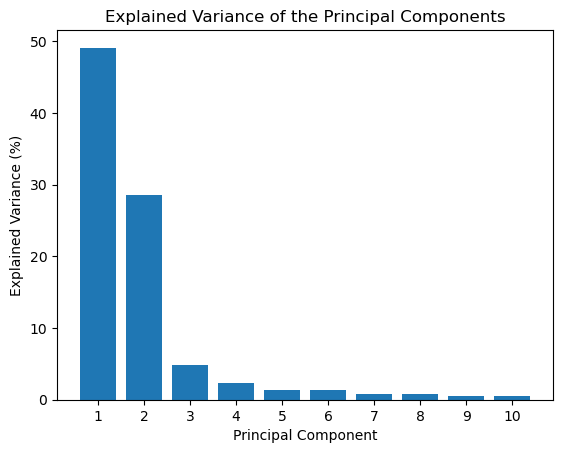

In [172]:
# barplot of explained variance of the first 10 components (plot components as integer)
components = [str(i+1) for i in range(10)]
plt.bar(components, explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance of the Principal Components')
plt.show()

In [173]:
finalDf = pd.concat([principalDf, pd.DataFrame(df_meta)], axis = 1)


In [174]:
finalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,Potassium_mass_mg_g,Protein_g_m2,RWC%,Starch_area_mg_cm2,Starch_mass_mg_g,Sugar_area_mg_cm2,Sugar_mass_mg_g,S_area_mg_cm2,S_mass_mg_g,Zn_mass_mg_g
0,-7.759353,-14.256097,-3.855888,1.999220,1.379828,-2.127186,-7.575824,-0.071695,0.293204,-7.371354,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1,21.172346,0.234877,-7.590979,1.298747,2.083590,-1.837885,-2.172772,1.586455,-0.128761,-4.553040,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
2,17.300545,-23.710320,-9.365911,2.272598,-0.438174,-0.811303,-8.500574,3.010103,0.222604,-4.407582,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
3,-11.707700,-13.967752,-9.500378,2.785065,1.359710,-2.154757,-3.947772,-1.393237,0.079937,-4.255448,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
4,-6.073761,-8.847635,4.285621,-0.757800,6.071730,-4.319275,-1.976247,0.825674,0.069397,-5.154035,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


In [175]:
# write PCA axis and traits to .csv
# Create a DataFrame from your array
#df = pd.DataFrame(finalDf)
# Save the DataFrame to a CSV file
finalDf.to_csv(model_out_dir + 'embedding_pca.csv', index=False, header=True , sep=',')

# Dimension reduction via variational autoencoder
## Prepare data loader for training

In [176]:
from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path):
        #self.x, self.standardizer, self.wine = load_data(path)
        self.x, self.standardizer, self.meta = load_data(path)
        self.x = numpyToTensor(self.x)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [177]:
# set the batch size
batch_size_train = 64

In [178]:
data_set=DataBuilder(data_path)
trainloader=DataLoader(dataset=data_set,batch_size=batch_size_train)

/tmp/ipykernel_2698635/428913080.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep=',')


In [179]:
type(trainloader.dataset.x)

torch.Tensor

In [180]:
data_set.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

## Implement variational autoencoder architecture and train model

In [181]:
class Autoencoder(nn.Module):
    def __init__(self,D_in,H=50,H2=12,latent_dim=5):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2=nn.Linear(H,H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3=nn.Linear(H2,H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)
        
#         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

#         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)
        
#         # Decoder
        self.linear4=nn.Linear(H2,H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5=nn.Linear(H2,H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6=nn.Linear(H,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [182]:
class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Compute the covariance matrix of the latent variables
        #mu_centered = mu - mu.mean(dim=0)
        #cov_matrix = mu_centered.t().mm(mu_centered) / mu_centered.size(0)
        
        # Add the sum of the off-diagonal elements to the loss
        #loss_cov = cov_matrix.sum() - torch.diag(cov_matrix).sum()

        #return loss_MSE + loss_KLD + loss_cov
        return loss_MSE + loss_KLD

In [183]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [184]:
D_in = data_set.x.shape[1]
H = 50
H2 = 12
model = Autoencoder(D_in, H, H2).to(device)
#model.apply(weights_init_uniform_rule)
#sae.fc4.register_forward_hook(get_activation('fc4'))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [185]:
loss_mse = customLoss()

# Train

In [186]:
epochs = 30000
log_interval = 50
val_losses = []
train_losses = []
loss_best = float(1000000) # loss value for initlization
if not os.path.exists(model_out_dir):
    os.makedirs(model_out_dir)

In [187]:
def train(epoch):
    global loss_best
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Calculate the average loss for the epoch
    average_loss = train_loss / len(trainloader.dataset)

    if loss_best > average_loss:
        torch.save(model.state_dict(), model_out_dir + 'model.pth')
        with open(model_out_dir + 'loss.txt', 'w') as f:
            f.write('loss: {:.6f}'.format(average_loss))
        loss_best = average_loss

    if epoch % 200 == 0:        
        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))
        with open(model_out_dir + 'losses.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            for loss in train_losses:
                writer.writerow([loss])

In [188]:
for epoch in range(1, epochs + 1):
    train(epoch)

====> Epoch: 200 Average loss: 926.6721
====> Epoch: 400 Average loss: 920.9285
====> Epoch: 600 Average loss: 918.1528
====> Epoch: 800 Average loss: 915.7106
====> Epoch: 1000 Average loss: 913.8598
====> Epoch: 1200 Average loss: 913.1175
====> Epoch: 1400 Average loss: 912.8036
====> Epoch: 1600 Average loss: 911.5082
====> Epoch: 1800 Average loss: 913.1017
====> Epoch: 2000 Average loss: 910.4761
====> Epoch: 2200 Average loss: 910.9166
====> Epoch: 2400 Average loss: 910.9245
====> Epoch: 2600 Average loss: 911.7736
====> Epoch: 2800 Average loss: 909.7386
====> Epoch: 3000 Average loss: 909.0795
====> Epoch: 3200 Average loss: 909.5240
====> Epoch: 3400 Average loss: 908.2425
====> Epoch: 3600 Average loss: 908.8046
====> Epoch: 3800 Average loss: 908.3240
====> Epoch: 4000 Average loss: 908.1230
====> Epoch: 4200 Average loss: 907.6138
====> Epoch: 4400 Average loss: 907.7172
====> Epoch: 4600 Average loss: 907.6131
====> Epoch: 4800 Average loss: 907.2611
====> Epoch: 5000 Av

# Evaluate the autoencoder

In [189]:
model.load_state_dict(torch.load(model_out_dir + 'model.pth'))

<All keys matched successfully>

In [190]:
#standardizer = trainloader.dataset.standardizer

In [191]:
recon_batches = []
data_batches = []
mu_batches = []
with torch.no_grad():
    for i, data in enumerate(trainloader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        mu_batches.append(mu)
        data_batches.append(data)
        recon_batches.append(recon_batch)

recon = torch.cat((recon_batches), dim = 0)
data = torch.cat((data_batches), dim = 0)
mu = torch.cat((mu_batches), dim = 0)

In [192]:
standardized_recon = standardizer.inverse_transform(recon.cpu().numpy())
standardized_data = standardizer.inverse_transform(data.cpu().numpy())
print("recon shape", standardized_recon.shape)
print("data shape", standardized_data.shape)
print("mu shape", mu.shape)

recon shape (5883, 2101)
data shape (5883, 2101)
mu shape torch.Size([5883, 5])


In [193]:
# select those column names that represent a value between 400 and 2500
spectracols = [col for col in df.columns if col.isdigit() and 400 <= int(col) <= 2500]
# convert the list of str to an int vector
spectraindex = [int(col) for col in spectracols]

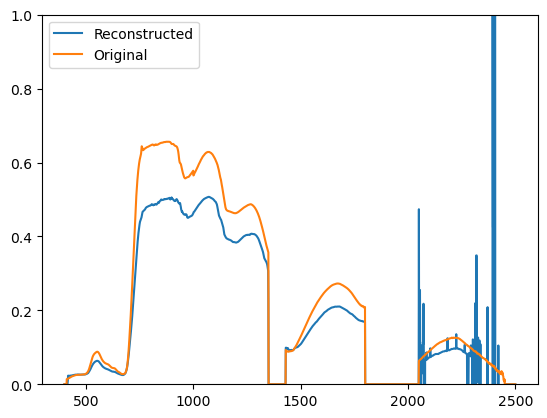

In [194]:
# Get the number of rows
num_rows = data.shape[0]

# Sample an index value within the number of rows
index = random.randint(0, num_rows-1)
plt.plot(spectraindex, standardized_recon[index], label='Reconstructed')
plt.plot(spectraindex, standardized_data[index], label='Original')
plt.ylim(0, 1)
plt.legend(loc='upper left')  # Add a legend
plt.show()

## Load and apply new data
... to be prepared

In [195]:
#data_set2=DataBuilder(DATA_PATH)
#inferenceloader=DataLoader(dataset=data_set2,batch_size=1)

In [196]:
#with torch.no_grad():
#    for i, data in enumerate(inferenceloader):
#        data_inf = data.to(device)
#        recon_batch, mu, logvar = model(data_inf)

# what about the standardizer?

## Apply the autoencoder to (heuristic) encodings

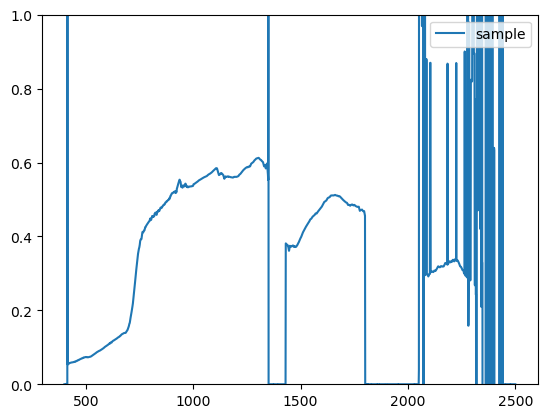

In [197]:
# apply the decoder of the variaitonal autoencoder to some heuristic latent space values
# and plot the resulting spectra
model.load_state_dict(torch.load(model_out_dir + 'model.pth'))
model.eval()
with torch.no_grad():
    z = torch.tensor([[2.53, 0.28, 1.123, 5.28, 8.123]]).to(device)
    sample = model.decode(z).cpu()
    sample = sample.numpy()
    sample = standardizer.inverse_transform(sample)
    plt.plot(spectraindex, sample[0], label = 'sample')
    plt.legend(loc = 'upper right')
    plt.ylim(0, 1)
    plt.show()

# Get Embeddings

In [198]:
mu_output = []
logvar_output = []

with torch.no_grad():
    for i, (data) in enumerate(trainloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)

            
            mu_tensor = mu   
            mu_output.append(mu_tensor)
            mu_result = torch.cat(mu_output, dim=0)

            logvar_tensor = logvar   
            logvar_output.append(logvar_tensor)
            logvar_result = torch.cat(logvar_output, dim=0)

In [199]:
mu_result.shape

torch.Size([5883, 5])

In [200]:
# explore first rows of the embedding
mu_result[0:10,:]

tensor([[ 4.8877e-04, -4.8789e-04,  6.9531e-01,  8.3053e-03, -1.3837e-03],
        [ 3.2194e-03,  1.3469e-03, -1.5242e-01,  1.1633e+00, -2.5863e-03],
        [ 6.1178e-03,  2.0666e-03,  7.0738e-01,  1.3712e+00, -4.6446e-03],
        [-3.7282e-04, -6.1506e-04,  7.4682e-01, -3.1982e-02, -1.5471e-03],
        [ 3.7247e-03,  4.3247e-04,  5.0214e-01,  3.7399e-01, -3.4045e-03],
        [ 4.7239e-03,  7.8396e-04,  4.6448e-01,  5.6177e-01, -3.5135e-03],
        [ 4.4373e-03,  1.3094e-03,  8.8376e-02,  1.0022e+00, -3.5036e-03],
        [-1.4407e-03,  1.6832e-03, -3.6799e-01,  1.8288e+00,  4.0987e-04],
        [-1.4579e-03,  1.4300e-03, -6.7539e-01,  1.6346e+00, -6.6327e-05],
        [ 2.5185e-03,  1.2880e-05,  4.2352e-01,  2.1137e-01, -2.1023e-03]],
       device='cuda:0')

In [201]:
numpy_array = mu_result.cpu().numpy()

In [202]:
# write emebddings to csv
#numpy_array = mu_result.numpy()

#np.savetxt(model_out_dir + 'embedding_train.csv', numpy_array, delimiter=',')

# write embeddings and traits to .csv
embeddings = pd.DataFrame(mu_result.cpu().numpy())
finalDf_vae = pd.concat([embeddings, pd.DataFrame(df_meta)], axis = 1)
finalDf_vae.to_csv(model_out_dir + 'embedding_vae.csv', index=False, header=True , sep=',')

In [203]:
finalDf_vae.head()

,0,1,2,3,4,Species,dataset,LandCover,Tool,Sensor,...,Potassium_mass_mg_g,Protein_g_m2,RWC%,Starch_area_mg_cm2,Starch_mass_mg_g,Sugar_area_mg_cm2,Sugar_mass_mg_g,S_area_mg_cm2,S_mass_mg_g,Zn_mass_mg_g
0,0.000489,-0.000488,0.695307,0.008305,-0.001384,Agrostis sp,1,Grassland,Proximal,ASD FieldSpec 3,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1,0.003219,0.001347,-0.152418,1.163265,-0.002586,Agrostis sp,1,Grassland,Proximal,SVC HR-1024TM,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
2,0.006118,0.002067,0.707383,1.371213,-0.004645,Agrostis sp,1,Grassland,Proximal,SVC HR-1024TM,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
3,-0.000373,-0.000615,0.746820,-0.031982,-0.001547,Agrostis sp,1,Grassland,Proximal,ASD FieldSpec 3,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
4,0.003725,0.000432,0.502136,0.373995,-0.003405,Angelica sylvestris,1,Grassland,Proximal,SVC HR-1024TM,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


# Basic plotting of the dimension reduction

## Plot Embeddings of PCA

In [204]:
from mpl_toolkits import mplot3d

# matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### continuous variable

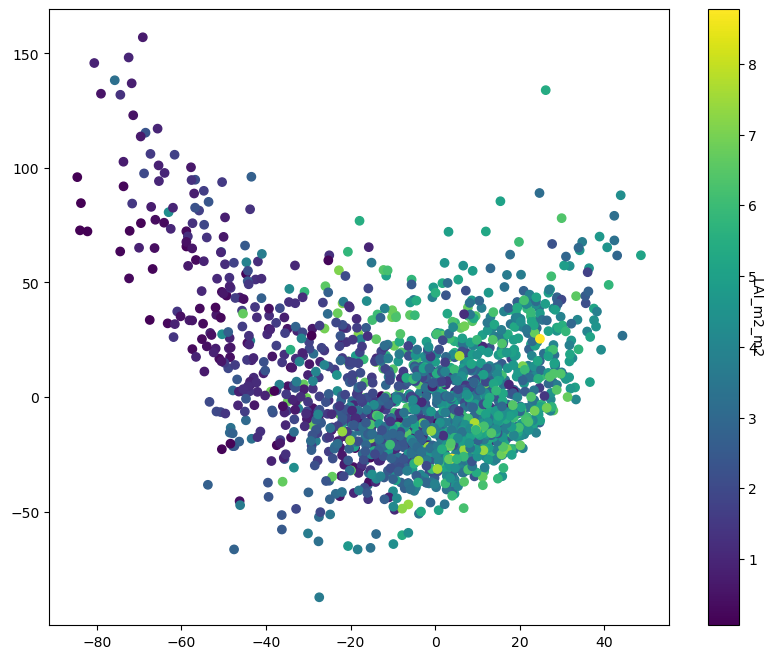

In [205]:
from sklearn.preprocessing import LabelEncoder

# Data for three-dimensional scattered points
variable = 'LAI_m2_m2'

filteredDf = finalDf[finalDf[variable] != -99]

metatype = filteredDf['LAI_m2_m2'].values

fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
ax = fig.add_subplot(111)

zdata = filteredDf.iloc[:,0].values
xdata = filteredDf.iloc[:,1].values
sc = ax.scatter(xdata, zdata, c=metatype, cmap='viridis')

cbar = plt.colorbar(sc)
cbar.set_label('LAI_m2_m2', rotation=270)

plt.show()


## Plot embeddings of autoencoder

### categorical variable

### continuous variable

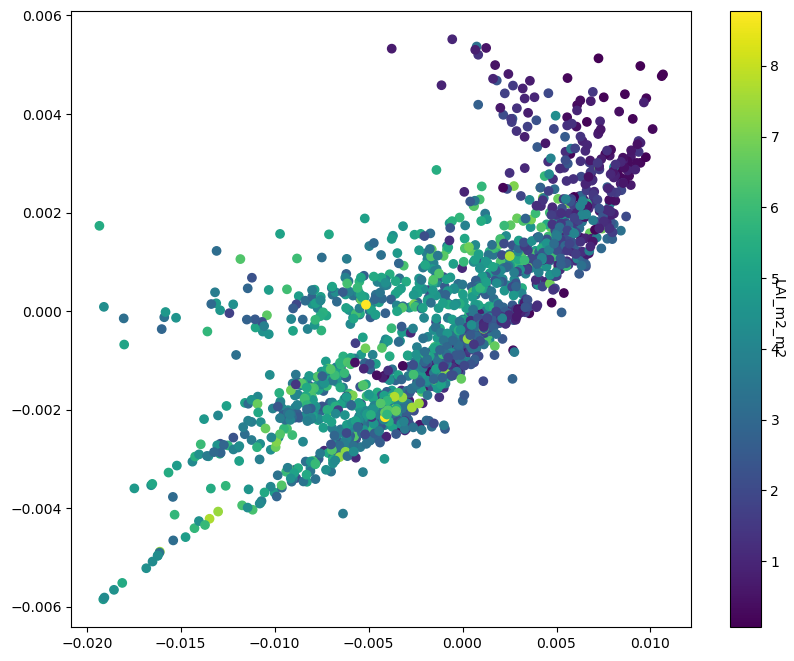

In [206]:
# Data for three-dimensional scattered points
# Data for three-dimensional scattered points

# Assuming finalDf is your DataFrame
#filteredDf = finalDf[(finalDf != -99).all(axis=1)]
#filteredmu_result = mu_result[(finalDf != -99).all(axis=1)]

variable = 'LAI_m2_m2'

filteredDf = finalDf[finalDf[variable] != -99]
filteredmu_result = mu_result[finalDf[variable] != -99]

metatype = filteredDf[variable].values

fig = plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
ax = fig.add_subplot(111)

ydata = filteredmu_result[:,1].cpu().numpy()
xdata = filteredmu_result[:,0].cpu().numpy()
sc = ax.scatter(xdata, ydata, c=metatype, cmap='viridis');

cbar = plt.colorbar(sc)
cbar.set_label('LAI_m2_m2', rotation=270)

plt.show()

## trash bin